<a href="https://colab.research.google.com/github/Ibraheem101/CineSense/blob/main/notebooks/CineSense_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Benchmark: https://paperswithcode.com/sota/text-classification-on-imdb

In [ ]:
!pip install transformers

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
import re
import json
import math
import nltk
import time
import torch
import gensim
import random
import urllib
import tempfile
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 93% 24.0M/25.7M [00:01<00:00, 25.2MB/s]
100% 25.7M/25.7M [00:01<00:00, 16.1MB/s]


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
df_url = "/content/IMDB Dataset.csv"
original_df = pd.read_csv(df_url)
original_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df = original_df.copy()
df.describe(include="all")

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
df["review"].iloc[:1].values

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

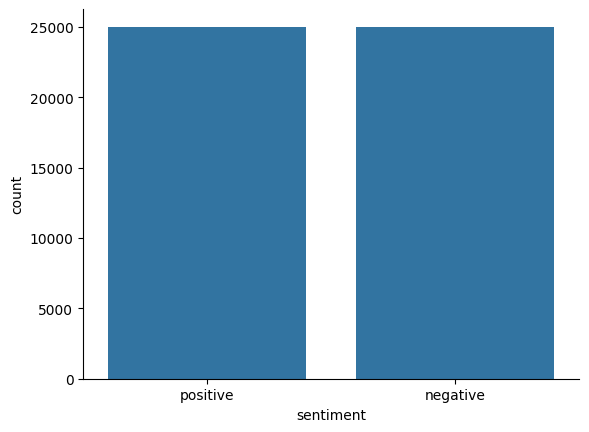

In [ ]:
sns.countplot(x=df.sentiment)
sns.despine()

In [ ]:
class_to_index = {
    "positive": 1,
    "negative": 0
}

# Decoding function
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [ ]:
df['sentiment'] = df['sentiment'].map(class_to_index)

In [ ]:
index_to_class = {value : key for key, value in class_to_index.items()}
decode(df['sentiment'].iloc[:5], index_to_class)

['positive', 'positive', 'positive', 'negative', 'positive']

In [ ]:
from wordcloud import WordCloud, STOPWORDS

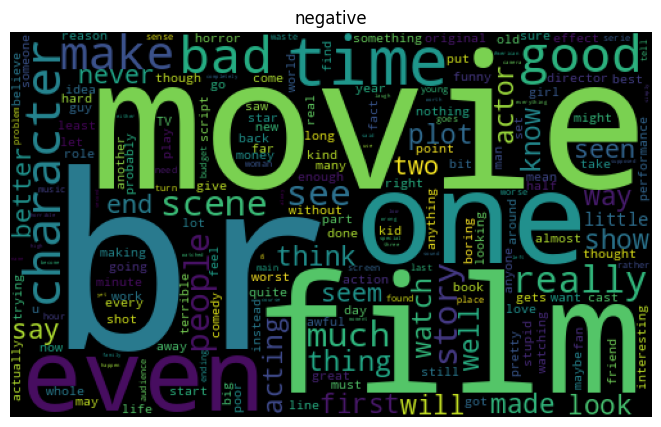

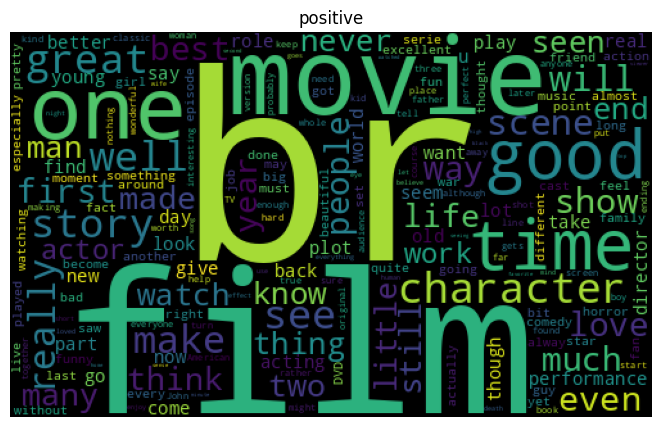

In [ ]:
# most frequent tokens for each target variable
targets = list(set(df.sentiment))
for target in targets:
    plt.figure(figsize=(13, 5))
    plt.title(index_to_class[target])
    subset = df[df.sentiment==target]
    text = subset.review.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black",
        collocations=False, width=500, height=300
    ).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text, stopwords = STOPWORDS):
    # lowercase
    text = text.lower()

    # Remove HTML tags
    text = text.replace("<br>", "")
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'<br\s*/?>', '', text)

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\
^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [ ]:
df["review"] = df["review"].apply(clean_text)

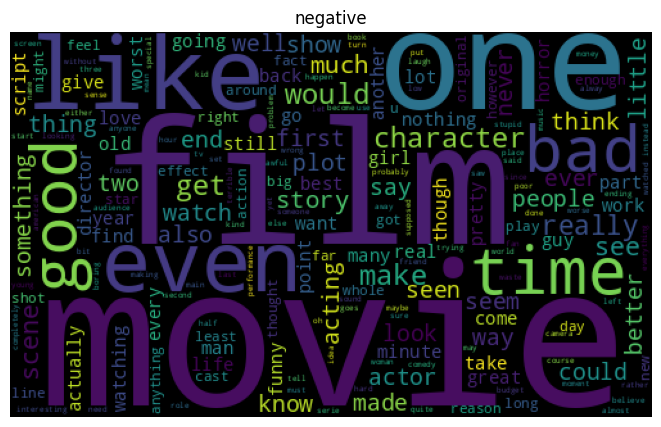

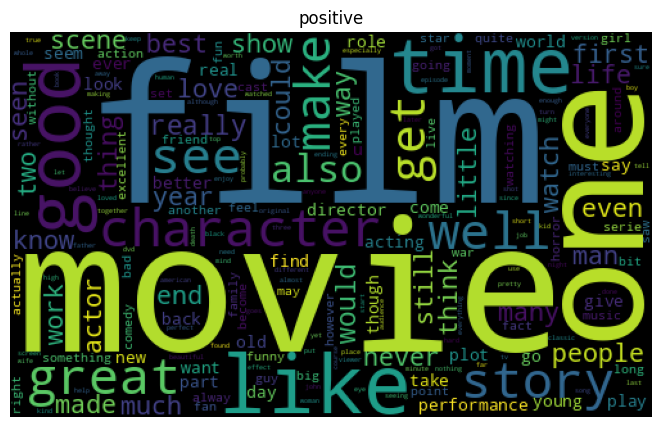

In [ ]:
# most frequent tokens for each target variable
targets = list(set(df.sentiment))
for target in targets:
    plt.figure(figsize=(13, 5))
    plt.title(index_to_class[target])
    subset = df[df.sentiment==target]
    text = subset.review.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black",
        collocations=False, width=500, height=300
    ).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

In [ ]:
df["review"].iloc[45], original_df["review"].iloc[45]

('disclaimer seen movie 5 6 times last 15 years saw musical week allowed judge movie without tainted musical however tainted watched musical actually believe michael douglas worked quite well role along kasey think let dance scene one best parts movie worthwhile addition compared musical dancers singing movie much superior musical well cast least 10 times bigger easier movie course decors lighting dancing singing also much superior movie expected indeed delivered songs common musical better done movie new ones quite good ones whole movie delivers musical opinion especially compared musical decors one bad point movie obvious cuts actors talking dubbed singers singing portions characters dancing impeccable end product enjoyable musical',
 "As a disclaimer, I've seen the movie 5-6 times in the last 15 years, and I only just saw the musical this week. This allowed me to judge the movie without being tainted by what was or wasn't in the musical (however, it tainted me when I watched the mus

In [ ]:
df["review"].iloc[4000], original_df["review"].iloc[4000]

('feels czech version pearl harbor story guys fall love woman add twist woman actually married one whose husband missing year think story line strong younger guy quite naughty cute kept watching emotional music pleasing scenes one another also strong visual special affects best love stories seamlessly integrated story think english would big shot across states bad many people open foreign movies',
 "This feels as if it is a Czech version of Pearl Harbor. It has a same story, both guys fall in love with the same woman. And add to the twist, the woman is actually a married one whose husband has been missing for a year. I don't think that the story line is too strong. The younger guy is quite naughty, that is cute. It kept me watching because of the emotional music, and the pleasing scenes one after another. It also has some strong visual special affects. Best of all, the love stories is seamlessly integrated with the story. <br /><br />I think that if it was in English, it would be such 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.data = df
        self.len = len(df)
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        text = str(self.data.review[index])
        target = self.data.sentiment[index]
        encoded_inputs = self.tokenizer(text,
                                        return_tensors="pt",
                                        padding="longest",
                                        truncation=True,
                                        max_length=self.max_length,
                                        pad_to_max_length=True
                                        )
        ids = encoded_inputs['input_ids'].flatten()
        mask = encoded_inputs['attention_mask'].flatten()

        return {
            'input_ids': ids,
            'attention_mask': mask,
            'targets': torch.tensor(target)
        }

    def __len__(self):
        return self.len

In [ ]:
# # Test
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=False)
# ds = CustomDataset(df, tokenizer=tokenizer, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split

In [ ]:
# Creating a function that returns the dataloader based on the dataframe and the specified train and validation batch size.

def return_dataloader(df, tokenizer, batch_size, max_length, n=3000, test_size=0.2):

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    df_sample = df.sample(n=n, random_state=42)
    train_dataset, val_dataset = train_test_split(df_sample, test_size=test_size, random_state=42)
    train_dataset = train_dataset.reset_index(drop=True)
    val_dataset = val_dataset.reset_index(drop=True)

    print("Complete Dataset: {}".format(df.shape))
    print("Sampled Dataset: {}".format(df_sample.shape))
    print("Train Dataset: {}".format(train_dataset.shape))
    print("Validation Dataset: {}".format(val_dataset.shape))

    training_set = CustomDataset(train_dataset, tokenizer, max_length)
    validation_set = CustomDataset(val_dataset, tokenizer, max_length)

    params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 1,
              'collate_fn': data_collator
              }

    # val_params = {'batch_size': batch_size,
    #                 'shuffle': True,
    #                 'num_workers': 1
    #                 }

    training_loader = DataLoader(training_set, **params)
    validation_loader = DataLoader(validation_set, **params)

    return training_loader, validation_loader

In [ ]:
#Test
train_loader, val_loader = return_dataloader(df, tokenizer, 64, 512, n=30000)

Complete Dataset: (50000, 2)
Sampled Dataset: (30000, 2)
Train Dataset: (24000, 2)
Validation Dataset: (6000, 2)


### Model

In [ ]:
F.softmax(torch.Tensor([[ 0.0574, -0.0954]]), dim=1).cpu().numpy()

array([[0.5381258 , 0.46187413]], dtype=float32)

In [ ]:
# test_model=DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [ ]:
# tokenizer.tokenize(df.review[0], )

In [ ]:
# test_model(tokenizer(df.review[0])['input_ids'], tokenizer(df.review[0])['attention_mask'])

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

    def forward(self, input_ids, attention_mask):
        z = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return z

    @torch.inference_mode()
    def predict(self, input_ids, attention_mask):
        self.eval()
        z = self(input_ids, attention_mask)
        y_pred = torch.argmax(z.logits, dim=1).cpu().numpy() #Added .logits()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, input_ids, attention_mask):
        self.eval()
        z = self(input_ids, attention_mask)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

In [ ]:
def return_base_model(device):
    model = BaseModel()
    model = model.to(device)
    return model

In [ ]:
# Accuracy function
def accuracy_score(preds, targets):
    acc = (preds==targets).float().mean()
    return acc

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
def train_base_model(train_loader, val_loader, epochs, device):
    model = return_base_model(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        results = []
        targets_arr = []

        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['targets'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, targets)

                ###
                preds = model.predict(input_ids=input_ids, attention_mask=attention_mask)
                results.append(preds)
                targets_arr.append(targets)
                ###

                val_loss += loss.item()

        results = torch.Tensor([item for sublist in results for item in sublist])
        targets_arr = torch.Tensor([item for sublist in targets_arr for item in sublist])
        acc = accuracy_score(results, targets_arr)

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss}. Validation Accuracy: {acc}")


    print("Training completed!")


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Instantiate tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", return_dict=False)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
epochs = 1
batch_size = 16
MAX_LEN = 512

# Get data loaders
train_loader, val_loader = return_dataloader(df, tokenizer, batch_size, MAX_LEN, n=30000)

# Instantiate the model

# Train the model
train_base_model(train_loader, val_loader, epochs, device)

Complete Dataset: (50000, 2)
Sampled Dataset: (30000, 2)
Train Dataset: (24000, 2)
Validation Dataset: (6000, 2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/1: 100%|██████████| 1500/1500 [13:45<00:00,  1.82batch/s]

Epoch 1/1, Training Loss: 0.30295455978562436


Epoch 1/1, Validation Loss: 0.23534183585643767. Validation Accuracy: 0.9028333425521851
Training completed!


In [ ]:
# logits=torch.Tensor([[-1.0232,  0.7083],
#         [-0.9412,  0.6713],
#         [-0.2773,  0.1761],
#         [-0.7750,  0.6170],
#         [ 0.5399, -1.0513],
#         [-0.2047,  0.0254],
#         [ 0.3730, -0.5200],
#         [ 0.0790, -0.2514],
#         [-0.5974,  0.4344],
#         [-0.9800,  0.7403],
#         [-0.8002,  0.7179],
#         [-0.2485,  0.0298],
#         [-0.8557,  0.7040],
#         [-0.4866,  0.4334],
#         [-0.0900, -0.1647],
#         [ 0.5228, -0.6827]])

In [ ]:
# lvwerra/distilbert-imdb

from transformers import DistilBertModel

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = DistilBertForSequenceClassification.from_pretrained('lvwerra/distilbert-imdb', return_dict=False)

    def forward(self, input_ids, attention_mask):
        z = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return z

    @torch.inference_mode()
    def predict(self, input_ids, attention_mask):
        self.eval()
        z = self(input_ids, attention_mask)
        y_pred = torch.argmax(z[0], dim=1).cpu().numpy() #Added .logits()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, input_ids, attention_mask):
        self.eval()
        z = self(input_ids, attention_mask)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

In [ ]:
def return_model(device):
    model = Model()
    model = model.to(device)
    return model

In [ ]:
def train_model(train_loader, val_loader, epochs, device):
    model = return_model(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        results = []
        targets_arr = []

        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs[0], targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['targets'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs[0], targets)

                ###
                preds = model.predict(input_ids=input_ids, attention_mask=attention_mask)
                results.append(preds)
                targets_arr.append(targets)
                ###

                val_loss += loss.item()

        results = torch.Tensor([item for sublist in results for item in sublist])
        targets_arr = torch.Tensor([item for sublist in targets_arr for item in sublist])
        acc = accuracy_score(results, targets_arr)

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss}. Validation Accuracy: {acc}")


    print("Training completed!")


In [ ]:
train_loader, val_loader = return_dataloader(df, tokenizer, batch_size, MAX_LEN, n=30000)

Complete Dataset: (50000, 2)
Sampled Dataset: (30000, 2)
Train Dataset: (24000, 2)
Validation Dataset: (6000, 2)


In [ ]:
train_model(train_loader, val_loader, epochs, device)

### Experiment Tracking
Tool: MLflow

In [ ]:
import mlflow